In [1]:
%matplotlib inline

# Exploratory Data Analysis (EDA)
This notebook will detail an exploratory data analysis of the sales dataset which will feed the forecasting model:
- As well, this will provide a quick way to check the generated/simulated data

In [2]:
import pandas as pd

In [3]:
sales_clusters_df=pd.read_csv('../data/raw/sales_cluster_table.csv')

In [4]:
sales_clusters_df.Cluster.value_counts()

3    148
4     78
0     32
1     17
2      4
Name: Cluster, dtype: int64

In [5]:
sales_clusters_df.head()

,product_code,noisy_date,noisy_quantity,Cluster
0,CLA0,2017-12-28,5038.619159,0
1,CLA0,2018-03-11,4658.195181,0
2,CLA0,2018-05-18,4676.433462,0
3,CLA0,2018-07-25,5067.550234,0
4,CLA0,2018-10-04,4602.628398,0


In [6]:
sales_clusters_df['noisy_date']=pd.to_datetime(sales_clusters_df['noisy_date'])

In [7]:
sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']]

,noisy_date,noisy_quantity
0,2017-12-28,5038.619159
1,2018-03-11,4658.195181
2,2018-05-18,4676.433462
3,2018-07-25,5067.550234
4,2018-10-04,4602.628398
5,2018-12-21,4873.462946
6,2019-02-21,5336.037630
7,2019-04-21,5112.239650
8,2019-07-07,5104.938014


In [8]:
sales_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
product_code      279 non-null object
noisy_date        279 non-null datetime64[ns]
noisy_quantity    279 non-null float64
Cluster           279 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.8+ KB


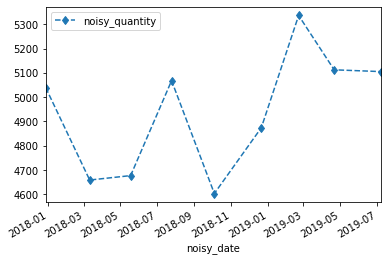

In [9]:
sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']]\
.plot.line(x='noisy_date',y='noisy_quantity',linestyle='--',marker='d')

# Just a small prophet model to try the library

In [10]:
from fbprophet import Prophet

In [11]:
model=Prophet()

In [12]:
prophet_df=sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']].copy()

In [13]:
prophet_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [14]:
prophet_df[:5]

,ds,y
0,2017-12-28,5038.619159
1,2018-03-11,4658.195181
2,2018-05-18,4676.433462
3,2018-07-25,5067.550234
4,2018-10-04,4602.628398


In [15]:
model.fit(prophet_df[:5])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
/anaconda3/envs/fastai/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [16]:
pd.DataFrame(prophet_df['ds'][5:])

,ds
5,2018-12-21
6,2019-02-21
7,2019-04-21
8,2019-07-07


In [17]:
forecast = model.predict(pd.DataFrame(prophet_df['ds']))

In [18]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-12-28,4904.934360,4660.448789,5149.908667
1,2018-03-11,4854.933152,4608.676343,5092.059455
2,2018-05-18,4808.356684,4582.389706,5041.833471
3,2018-07-25,4761.780216,4527.887211,5013.234764
4,2018-10-04,4713.148903,4479.112283,4962.547501
5,2018-12-21,4659.722952,4427.643827,4908.613278
6,2019-02-21,4617.256172,4380.354612,4869.488968
7,2019-04-21,4576.844235,4329.549643,4824.296059
8,2019-07-07,4524.103233,4294.270289,4780.872451


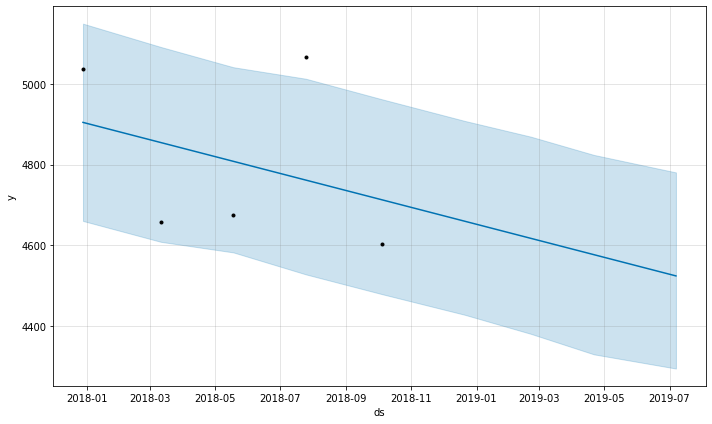

In [19]:
fig1 = model.plot(forecast)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode()

fig = plot_plotly(model, forecast)  # This returns a plotly Figure
py.iplot(fig)

# Clusters analysis

In [21]:
import plotly.graph_objects as go

In [22]:
sales_clusters_df.head()

,product_code,noisy_date,noisy_quantity,Cluster
0,CLA0,2017-12-28,5038.619159,0
1,CLA0,2018-03-11,4658.195181,0
2,CLA0,2018-05-18,4676.433462,0
3,CLA0,2018-07-25,5067.550234,0
4,CLA0,2018-10-04,4602.628398,0


In [23]:
sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 273
Data columns (total 2 columns):
noisy_date        32 non-null datetime64[ns]
noisy_quantity    32 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 768.0 bytes


In [ ]:
fig = go.Figure()

for cluster in sales_clusters_df.Cluster.value_counts().index.values:
    
    fig.add_trace(go.Scatter(x=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_date'].astype(str).values,
                             y=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values,
                        mode='markers',
                        name='Cluster '+str(cluster)))

# Edit the layout
fig.update_layout(title='Labels Sales per cluster',
                   xaxis_title='Date',
                   yaxis_title='Quantities')


fig.show()

# Cluster #0 predictions

In [142]:
cluster_prophet_df=sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].copy()

In [143]:
cluster_prophet_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [171]:
cluster_prophet_df.describe()

,y
count,32.000000
mean,5156.820343
std,1486.038537
min,1522.967281
25%,4997.330106
50%,5358.677428
75%,6118.406462
max,7394.180590


In [172]:
cluster_prophet_df=cluster_prophet_df.sort_values('ds')
cluster_prophet_df['cap'] = 8000
cluster_prophet_df['floor'] = 1300

In [173]:
cluster_model=Prophet(growth='logistic',
                      changepoint_prior_scale= 0.001)

In [174]:
cluster_model.fit(cluster_prophet_df[:25])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
/anaconda3/envs/fastai/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [175]:
cluster_prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 17 to 31
Data columns (total 4 columns):
ds       32 non-null datetime64[ns]
y        32 non-null float64
cap      32 non-null int64
floor    32 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.2+ KB


In [182]:
cluster_forecast = cluster_model.predict(pd.DataFrame(cluster_prophet_df[['ds','cap','floor']]))

In [183]:
cluster_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2019-04-21,5595.279337,3749.502534,7204.779148
28,2019-04-30,5419.764128,3518.268551,7171.173594
29,2019-05-29,5314.801174,3590.888411,7171.139206
30,2019-07-07,5559.562909,3800.803262,7331.447039
31,2019-07-14,5556.312287,3802.253520,7453.955551


In [184]:
cluster_prophet_df.tail()

,ds,y,cap,floor
7,2019-04-21,5112.239650,8000,1300
273,2019-04-30,1776.849890,8000,1300
30,2019-05-29,6215.565413,8000,1300
8,2019-07-07,5104.938014,8000,1300
31,2019-07-14,5517.380754,8000,1300


In [185]:
cluster_prophet_df[:25]

,ds,y,cap,floor
17,2017-12-26,6314.400966,8000,1300
0,2017-12-28,5038.619159,8000,1300
270,2017-12-30,1522.967281,8000,1300
54,2017-12-31,6572.009204,8000,1300
18,2018-02-11,6181.772772,8000,1300
1,2018-03-11,4658.195181,8000,1300
19,2018-03-19,5577.890228,8000,1300
20,2018-05-01,5241.655174,8000,1300
2,2018-05-18,4676.433462,8000,1300
21,2018-06-06,5274.909501,8000,1300


In [186]:
import matplotlib.pyplot as plt

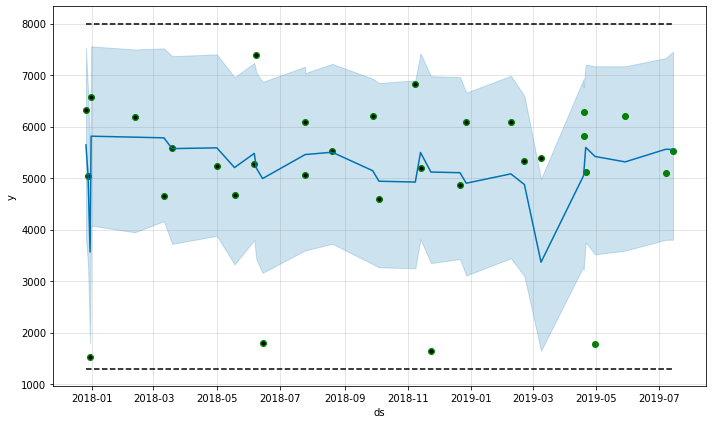

In [187]:
fig1 = cluster_model.plot(cluster_forecast)
plt.scatter(cluster_prophet_df['ds'],
           cluster_prophet_df['y'],color='g')

# Next steps: tuning + ARIMA 